In [5]:
### ML with a NN model to learn weights. Train set is output of IOC
### Author : Marina Draskovic 
### Email  : mdraskovic@ethz.ch 
### Date   : 26. August 2022.
import os, sys
current = os.path.dirname(os.path.abspath(''))
parent = os.path.dirname(current)
sys.path.append(current)
sys.path.append(parent) 

import csv
import numpy as np
import pinocchio as pin
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
torch.Generator().manual_seed(42)
from IOC.OCP import OptimalControlProblem
from utils import ArmDataset, WeightsModel, create_w

In [7]:
### Load data ###
# Open csv file
save_file = '../../setup5.csv'
with open(save_file, 'r') as results_file: # Open in read mode
    csv_reader = csv.reader(results_file)  # Load csv data
    data = np.array(list(csv_reader)) 
data = data[1:,:]                          # Remove header

# Initialize ML train data : X = [q, q', target] ; y = w
len_data = data.shape[0]
X = torch.zeros((len_data, 11))       # [q (len 4), q' (len 4), target (len 3)] 
Y = torch.zeros((len_data, 4))        # Weights
error_real_ioc = torch.zeros(len_data) # ||Xref - Xioc||^2 - Used later to study results

# Load data to tensors
for row in range(len_data):           # Go through all rows
    x0 = torch.from_numpy(utils.get_element(data, row, 15))
    X[row, :4] = x0[:4]               # Removing wrist joint state as its fixed to 0 
    X[row, 4:8] = x0[5:9]
    X[row, 8:] = torch.from_numpy(utils.get_element(data, row, 3))
    Y[row, :] = torch.from_numpy(utils.get_element(data, row, 8))
    error_real_ioc[row] = float(data[row, 11]) 
    
# Normalize labels
mean_w1, std_w1 = torch.std_mean(Y[:,0])
mean_w2, std_w2 = torch.std_mean(Y[:,1])
mean_w3, std_w3 = torch.std_mean(Y[:,2])
mean_w4, std_w4 = torch.std_mean(Y[:,3])
normalizedY = torch.zeros((len_data, 4))
normalizedY[:,0] = (Y[:,0] - mean_w1)/std_w1
normalizedY[:,1] = (Y[:,1] - mean_w2)/std_w2
normalizedY[:,2] = (Y[:,2] - mean_w3)/std_w3
normalizedY[:,3] = (Y[:,3] - mean_w4)/std_w4

# Create a dataset
dataset = ArmDataset(X,normalizedY)
input_size = X.shape[1]
output_size = normalizedY.shape[1]

# Create train (80%) and test (20%) sets
data_size = len(dataset)
dataset_train, dataset_test = torch.utils.data.random_split(dataset, [round(0.8*data_size), round(0.2*data_size)]) 

# Save indices of test data
test_ind = dataset_test.indices

# Create batches
train = DataLoader(dataset_train, batch_size = 128, num_workers = 12, shuffle=True)
test = DataLoader(dataset_test, batch_size = len(dataset_test), num_workers = 12, shuffle=True)

In [8]:
### ML ###
# Params
learning_rate = 1.0e-3
max_epochs = 600
loss_fun = nn.L1Loss()
nn_model = WeightsModel(input_size, output_size)

optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=1e-3)

# Initialize lists to save loss values
train_losses = []
test_losses = []

# Run algorithm
for t in range(max_epochs):

    # Train
    nn_model.train()
    batch_train_losses = []
    for x_train_batch, y_train_batch in train: # Go thru batch
        # FW Pass: y_hat = f_hat(x)
        y_pred = nn_model(x_train_batch)
        loss = loss_fun(y_pred, y_train_batch) 
        batch_train_losses.append(loss.detach().numpy())

        # BW Pass :
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    mean = np.mean(batch_train_losses)
    train_losses.append(mean) # Add mean of the batch loss to the list of train losses
    
    # Print progress
    if t%100 == 0:
        print("Iteration : ", t, " Loss :" , mean)

    # Test
    batch_test_losses = []
    nn_model.eval()
    with torch.no_grad():
        for x_test_batch, y_test_batch in test:
            y_pred = nn_model(x_test_batch)
            batch_test_loss = loss_fun(y_pred, y_test_batch) 

    test_losses.append(batch_test_loss)

Iteration :  0  Loss : 1.2700511
Iteration :  100  Loss : 0.44542122
Iteration :  200  Loss : 0.41192126
Iteration :  300  Loss : 0.39138404
Iteration :  400  Loss : 0.37980407
Iteration :  500  Loss : 0.36620933


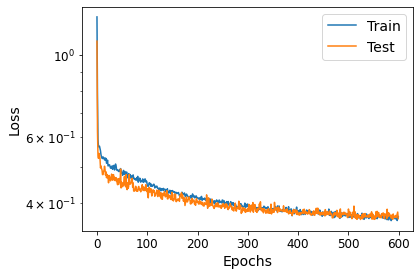

In [20]:
### Plot Train and Test Loss sum{| W_ioc - W_ml| } ###
plt.rc('legend', fontsize=14)
plt.rc('axes', labelsize=14)

torch.save(nn_model.state_dict(), "./model_dummy" )  

# Plot
fig,ax = plt.subplots(1,1)
ax.plot(train_losses, label = "Train")
ax.plot(test_losses, label = "Test")

ax.set(xlabel = 'Epochs')
ax.set_yscale('log')
ax.set(ylabel = 'Loss')
plt.grid()
ax.legend()

plt.tight_layout()
fig.savefig("train-test-loss.pdf")

In [27]:
### Check results ###
DT = utils.DT
T = utils.T
robot_urdf = utils.robot_urdf
mesh_dir = utils.mesh_dir
end_effector = utils.end_effector
robot_model, _, _  = pin.buildModelsFromUrdf(robot_urdf, mesh_dir)
robot_data = robot_model.createData()
ocp = OptimalControlProblem(robot_model, robot_data, DT, T, end_effector)

nn_model = WeightsModel(input_size, output_size)
nn_model.load_state_dict(torch.load("./model_dummy"))
nn_model.eval()

# Get ||EEF_real - EEF_ioc||^2 for correct idxs
errors_real_ioc = [] # error_real_ioc[test_ind]
errors_real_ml = []
errors_ioc_ml = []

eefs_real = []
eefs_ioc = []
eefs_ml = []

w_list = []
x0_list = []
target_list = []
cnt = 0

for i, j in zip(test_ind, dataset_test): # Go through all test set ; 'i' is idx in original dataset
    
    # Check if its the original or MPC trajectory
    cluster_folder = data[i,0]
    target_file_name = [e for e in data[i,1].split(' ')] 
    if len(target_file_name) == 1: # Original traj
        folder_name = '../../'+cluster_folder + '/' + target_file_name[0]
    else:
        folder_name = '../../MPC/' + cluster_folder + '/' + target_file_name[0] + '/' + target_file_name[1]
    
    
    # Real trajectory
    trajectory_real = np.loadtxt(folder_name+'/traj_OCP.txt', comments="#", delimiter=" ", unpack=False)
    eef_real = ocp.get_eef(trajectory_real)
    eefs_real.append(eef_real)
    
    # IOC trajectory
    x0 = utils.get_element(data, i, 15)
    target = utils.get_element(data, i, 3)
    w = utils.get_element(data, i, 8)
    running_w, terminal_w = utils.create_w(w)
    
    trajectory_ioc, _, _ = ocp.run(x0, target, running_w, terminal_w, do_print=False, do_print_logs=False)
    eef_ioc = ocp.get_eef(trajectory_ioc)
    eefs_ioc.append(eef_ioc)
    
    # ML trajectory
    nn_model.eval()
    w = nn_model(j[0]).detach().numpy()[0]
    w[0] = w[0]*std_w1 + mean_w1 # De-normalize
    w[1] = w[1]*std_w2 + mean_w2
    w[2] = w[2]*std_w3 + mean_w3
    w[3] = w[3]*std_w4 + mean_w4
    w[w <0.0001] = 0.0001 # Set bounds
    w[w >100.0] = 100.0

    running_w, terminal_w = utils.create_w(w)
    trajectory_ml, _, tf = ocp.run(x0, target, running_w, terminal_w, do_print=False, do_print_logs=False)
    eef_ml = ocp.get_eef(trajectory_ml)
    eefs_ml.append(eef_ml)
    
    # Calculate ||EEF_real - EEF_ioc||^2, ||EEF_real - EEF_ml||^2 and ||EEF_ioc - EEF_ml||^2
    error_real_ioc = max(np.linalg.norm(eef_real-eef_ioc, axis=1, ord=2))*100
    error_real_ml = max(np.linalg.norm(eef_real-eef_ml, axis=1, ord=2))*100 # Ideally same as error_real_ioc
    error_ioc_ml = max(np.linalg.norm(eef_ioc-eef_ml, axis=1, ord=2))*100   # Ideally zero
    if error_ioc_ml>15 or error_real_ml>15 or error_real_ml>15:    
        continue
        
    errors_real_ioc.append(error_real_ioc)   
    errors_real_ml.append(error_real_ml)
    errors_ioc_ml.append(error_ioc_ml)
    
    w_list.append(w)
    x0_list.append(x0)
    target_list.append(target)
    cnt+=1

In [28]:
mean_real_ioc = np.mean(errors_real_ioc)
std_real_ioc = np.std(errors_real_ioc)

mean_real_ml = np.mean(errors_real_ml)
std_real_ml = np.std(errors_real_ml)

mean_ioc_ml = np.mean(errors_ioc_ml)
std_ioc_ml = np.std(errors_ioc_ml)

print("REAL IOC : ", mean_real_ioc, std_real_ioc)
print("REAL ML : ", mean_real_ml, std_real_ml)
print("IOC ML : ", mean_ioc_ml, std_ioc_ml)

REAL IOC :  3.670777388286174 3.117973555328767
REAL ML :  4.208548336354113 3.186181253803238
IOC ML :  2.279180559549819 2.77032640145152


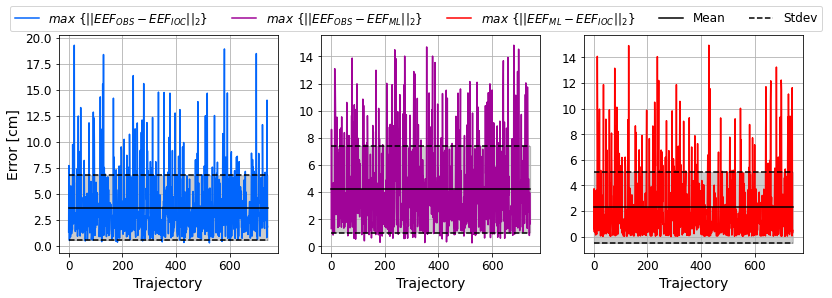

In [29]:
### Plots metric results ###
plt.rc('legend', fontsize=12)
plt.rc('axes', labelsize=14)

trajs = range(len(errors_real_ml))
fig1,ax1 = plt.subplots(1,3, figsize=plt.figaspect(0.3))
ax1[0].plot(trajs, errors_real_ioc, label=r'$max\ \{||EEF_{OBS} - EEF_{IOC}||_2\}$', color='xkcd:bright blue')
ax1[1].plot(trajs, errors_real_ml, label=r'$max\ \{||EEF_{OBS} - EEF_{ML}||_2\}$', color='xkcd:barney purple')
ax1[2].plot(trajs, errors_ioc_ml, label=r'$max\ \{||EEF_{ML} - EEF_{IOC}||_2\}$', color='red')

# MEAN
ax1[0].plot(trajs, [mean_real_ioc]*len(trajs), color='black')
ax1[1].plot(trajs, [mean_real_ml]*len(trajs), color='black')
ax1[2].plot(trajs, [mean_ioc_ml]*len(trajs), color='black', label=r'Mean')

# STDEV
ax1[0].fill_between(trajs, mean_real_ioc-std_real_ioc, mean_real_ioc+std_real_ioc, alpha=.2, color='black')
ax1[0].plot(trajs, [mean_real_ioc-std_real_ioc]*len(trajs), color='black', linestyle='dashed')
ax1[0].plot(trajs, [mean_real_ioc+std_real_ioc]*len(trajs), color='black', linestyle='dashed')

ax1[1].fill_between(trajs, mean_real_ml-std_real_ml, mean_real_ml+std_real_ml, alpha=.2, color='black')
ax1[1].plot(trajs, [mean_real_ml-std_real_ml]*len(trajs), color='black', linestyle='dashed')
ax1[1].plot(trajs, [mean_real_ml+std_real_ml]*len(trajs), color='black', linestyle='dashed')

ax1[2].fill_between(trajs, mean_ioc_ml-std_ioc_ml, mean_ioc_ml+std_ioc_ml, alpha=.2, color='black')
ax1[2].plot(trajs, [mean_ioc_ml-std_ioc_ml]*len(trajs), color='black', linestyle='dashed')
ax1[2].plot(trajs, [mean_ioc_ml+std_ioc_ml]*len(trajs), color='black', linestyle='dashed', label=r'Stdev')

# Axis
ax1[0].set(xlabel='Trajectory', ylabel = r'Error [cm]')
ax1[1].set(xlabel='Trajectory')
ax1[2].set(xlabel='Trajectory')

fig1.legend(ncol=5, loc="upper center")

plt.show()
fig1.savefig("ml-errors.pdf")

In [35]:
from matplotlib import gridspec
from matplotlib.lines import Line2D
def three_eef_trajectories(eef1, eef2, eef3, title, DT):
    """Plot original and recreated trajectories in 3D. Plot each trajectory axis wrt time and errors
    between them. Possibly print all intermediate trajectories through optimization iterations.

    ----Parameters----
        eef1  : optimal, real eef traj
        eef2  : ioc recreated traj
        eef3  : ml traj
        title : used to specify which target it is
        DT    : DDP timestep
        trajs_iterations : intermediate trajectories
    """
    fig = plt.figure(figsize=(11,5))
    gs  = gridspec.GridSpec(1,4, width_ratios=[0.3,0.3,0.3,1 ])
    ax = fig.add_subplot(122, projection = '3d')
    ax1 = fig.add_subplot(gs[0]); ax2 = fig.add_subplot(gs[1]); ax3 = fig.add_subplot(gs[2]) # Subplots for trajs wrt time
    t = np.arange(0, eef1.shape[0], 1)*DT

    # Plot eef trajectories
    ax.plot(eef1.T[0]*100, eef1.T[1]*100, eef1.T[2]*100, color='xkcd:green apple')
    ax.scatter(*eef1[0]*100, color = 'xkcd:green apple') # Mark starting point
    ax.plot(eef2.T[0]*100, eef2.T[1]*100, eef2.T[2]*100, color='xkcd:bright blue', linestyle='dashed')
    ax.scatter(*eef2[0]*100, edgecolor = 'xkcd:bright blue', marker='D', c='none') 
    ax.set_xlabel(r'x [cm]'); ax.set_ylabel(r'y [cm]'); ax.set_zlabel(r'z [cm]')
    ax.plot(eef3.T[0]*100, eef3.T[1]*100, eef3.T[2]*100, color='xkcd:barney purple', linestyle='dashed')

    
    # Plot eef trajectories wrt time and errors
    error = abs(eef1-eef2)
    for i, a in zip(range(3),[ax1, ax2, ax3]):
        a.plot(t, eef1[:,i]*100, linewidth=2.0, color='xkcd:green apple')
        a.plot(t, eef2[:,i]*100, linewidth=2.0, color='xkcd:bright blue', linestyle='dashed')
        a.plot(t, eef3[:,i]*100, linewidth=2.0, color='xkcd:barney purple', linestyle='dashed')

    # Modify plot
    ax.dist = 9.5 # Modify size of 3d plot
    ax1.set(ylabel=r'EEF trajectory [cm]', title=r'$x$ axis')
    ax2.set(title=r'$y$ axis'), ax3.set(title=r'$z$ axis')
    ax1.set(xlabel=r"Time [s]"), ax2.set(xlabel=r"Time [s]"), ax3.set(xlabel=r"Time [s]")
    legend = [Line2D([0], [0],  lw=2, label='Optimal trajectory', color='xkcd:green apple'),
            Line2D([0], [0],  lw=2, label='IOC trajectory', color='xkcd:bright blue', linestyle='dashed'),
            Line2D([0], [0],  lw=2, label='ML trajectory', color='xkcd:barney purple', linestyle='dashed')]
    fig.legend(handles=legend, loc='lower right', ncol=3)

    # fig.suptitle(title)
    fig.savefig("ml.pdf")

----------------------
Target is  [0.58547884 0.08095364 0.34999454]
Problem solved: True
Number of iterations: 72
Total cost: 1.6621283663776685
Gradient norm: 2.874162909349568e-10
Finally reached:  [0.58548114 0.08092607 0.35004722]


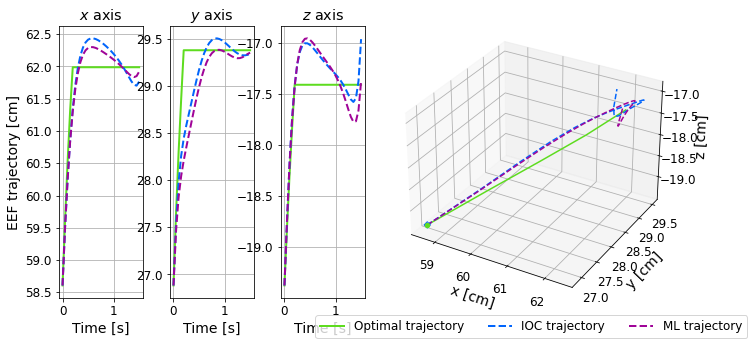

In [36]:
idx = 438 # Which trajectory from the test set is plotted

w= w_list[idx]
running_w, terminal_w = utils.create_w(w)
trajectory_ml, _,_ = ocp.run(x0_list[idx], target_list[idx], running_w, terminal_w, do_print=True, do_print_logs=False)

three_eef_trajectories(eefs_real[idx], eefs_ioc[idx], eefs_ml[idx], "Real, IOC and ML Trajectories", DT)
plt.savefig("ml.pdf")